# Data Scientist Professional Case Study

### Company Background

Snow Cone Games are a digital retailer for video games. The website includes a simple filter for the genre of the game as well as more advanced filtering. The product manager has recently learned that only 23% of buyers search for games using the genre filter. 

71% of buyers use advanced filters to find the types of games that appeal to them. The product manager hopes that new categories based on different game attributes can help players find what they are looking for faster.


### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?


### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.


### Dataset

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

# 0. Definition of the problem
- Problem: find the best way to group features.
- Limitations: No more than 5 groups (clusters). Business Goal
- Problem type: **Clustering** (Unsupervised Learning). We are looking for correlations in the data without outputs to train on. In other words, we attempt to group data based on the similarity of different dimensions.

> About clustering:
- process of grouping items with similar characteristics.
- items in groups similiar to each other than in other groups.
> Clustering algorithms:
- Hierarchical clustering (runtime increases with data so it is not feasible for this 40k dataset)
- **K Means clustering**
- Other: DBSCAN, Gaussian Methods.
> K Means assumptions
- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

# 1. Import necessary libraries and loading data

In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ML libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Configure visualizations
plt.rcParams['figure.figsize'] = [8, 4]
sns.set_theme(style='darkgrid') # Set visualization style

# Load the data
df = pd.read_csv('data/video_games.csv')

# 2. Data validation

Before starting, we need to spend some time preparing our data for cluster analysis:
- Variable have incomparable units (dimensions: $, cm...)
- Variables with same units have different scales and varianes
- Data in raw form may lead to bias in clustering
- Clusters may be heavily dependent on one variable
- Solution: normalization of individual variables. Rescale data to a standard deviation of 1.

scipy.cluster.vq import whiten

scaled_data = whiten(data)

## 2.1 EDA

In [2]:
print("The shape of the dataframe is: ", df.shape)

The shape of the dataframe is:  (40833, 9)


In [3]:
df.head()

NameError: name 'df' is not defined

From the [head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) function we can come up that 'name' and 'developer' feature have no relevance on futures predictions because we only got 1 single or maybe 2 repetitions. So we have got 7 features.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40817 non-null  object 
 1   release_date      37654 non-null  object 
 2   developer         40490 non-null  object 
 3   achievements      12194 non-null  float64
 4   original_price    35522 non-null  object 
 5   percent_positive  17363 non-null  object 
 6   num_reviews       17363 non-null  float64
 7   multiplayer       40313 non-null  object 
 8   mature            40833 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.5+ MB


In [5]:
print(len(df['name'].unique()))
print(len(df['developer'].unique()))

40750
17421


**name and developer** it is approximately a unique identifier for each of the instances

From [info()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html) object we get the following conclussions:
- There are missing values, we can report the % of missing values
- 'object' data types need adjustment to either categories, int, float, bool...
- *name* and *developer* can be dropped because is not going to help on predictions.
- *release_date* can be transformed to datetime or maybe extract the year.
- *original_price* can be transformed to float type
- *percent_positive* can be transformed to int
- *multiplayer* can be transformed to bool.
- *mature* seems ready to go.

In [6]:
df.original_price.value_counts

<bound method IndexOpsMixin.value_counts of 0        $19.99
1        $29.99
2        $39.99
3        $44.99
4          Free
          ...  
40828     $2.99
40829     $2.99
40830     $7.99
40831     $9.99
40832     $4.99
Name: original_price, Length: 40833, dtype: object>

Let's consider non price rows as Free Games, 0$

### Missing values

In [7]:
# % of missing values on each feature
missing_values = (df.isnull().sum()/df.shape[0]*100).sort_values(ascending = False).round(2)
missing_values

achievements        70.14
percent_positive    57.48
num_reviews         57.48
original_price      13.01
release_date         7.79
multiplayer          1.27
developer            0.84
name                 0.04
mature               0.00
dtype: float64

## 2.2 Data Cleaning
We need to take care of all missing values, wrong data... before proceed with further anlysis

In [8]:
df['release_date'].value_counts()

2019               296
Coming Soon        134
Nov 1, 2018        124
Mar 12, 2019       120
Apr 4, 2019         76
                  ... 
Mar 8, 2005          1
Early Next Year      1
May 28, 2009         1
Sep 16, 2009         1
Mar 29, 2002         1
Name: release_date, Length: 4107, dtype: int64

In [9]:
def preprocessing(df):
    # 1 Drop 'name' and 'developer' feature
    df.drop(['name','developer'], axis=1, inplace = True)
    
    # 2 'release_date' to release_year, we can use an endless dictionary to get the whole date, but for now, we take the year
    replaces = {'2019': 'Jan 1, 2019',
                   'Coming Soon': np.nan,
                   'TBA': np.nan,
                   'Q3 2019 wishlist': 'Jan 1, 2019',
                   '2019/2020': 'Jan 1, 2019',
                   'EM BREVE': np.nan,
                   '20/06/2019': 'Jun 20, 2019',
                }
    df['release_date'] = df['release_date'].replace(to_replace=replaces)
    df['release_year'] = df['release_date'].str.findall('(?<!\d)\d{4}(?!\d)').str[0]
    df['release_year'].fillna(method="ffill", inplace = True)
    df['release_year'] = df['release_year'].astype(int)
    df.drop('release_date', axis=1, inplace = True)
    
    #Dropping the outliers.
    df = df[(df["release_year"]<2023)]
    
    # 3 'achievements' fill nan with 0, which means no achievements
    df['achievements'].fillna(0, inplace=True)
    
    # 4 'original_price' cleaning dollar sign
    df[['delete','price']] = (df['original_price']
                          .str
                          .split('$', expand=True)) # expand gives a df instead of series
    df['price'].fillna(0, inplace=True)
    df['price'] = df['price'].astype(float)
    df.drop(['original_price','delete'], axis=1, inplace=True)
    
    # 5 'num_reviews' fill nan with 0, which means there are no reviews
    df['num_reviews'].fillna(0, inplace=True)
    
    # 6 'multiplayer' fill nan with False, which means the game is single player
    df['multiplayer'].fillna(False, inplace=True)
    
    # 7 percent_positive
    df[['percent_pos','delete']] = (df['percent_positive'].str.split('%', expand=True))
    df.drop(['delete','percent_positive'], axis=1, inplace=True)
    df['percent_pos']po.fillna(0, inplace = True)
    df['percent_pos'] = df['percent_pos'].astype(int)
    
    return df


In [10]:
data = preprocessing(df)
data.head(5)

,achievements,num_reviews,multiplayer,mature,release_year,price,percent_pos
0,54.0,42550.0,True,False,2016,19.99,92
1,37.0,836608.0,True,True,2017,29.99,49
2,128.0,7030.0,True,False,2018,39.99,71
3,0.0,167115.0,True,False,2018,44.99,61
4,0.0,11481.0,True,False,2003,0.00,74


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40831 entries, 0 to 40832
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   achievements  40831 non-null  float64
 1   num_reviews   40831 non-null  float64
 2   multiplayer   40831 non-null  bool   
 3   mature        40831 non-null  bool   
 4   release_year  40831 non-null  int64  
 5   price         40831 non-null  float64
 6   percent_pos   40831 non-null  int64  
dtypes: bool(2), float64(3), int64(2)
memory usage: 1.9 MB


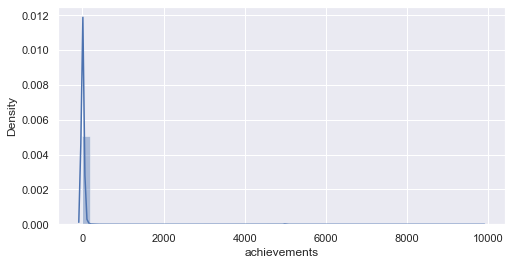

In [12]:
sns.distplot(data['achievements'])
plt.show()

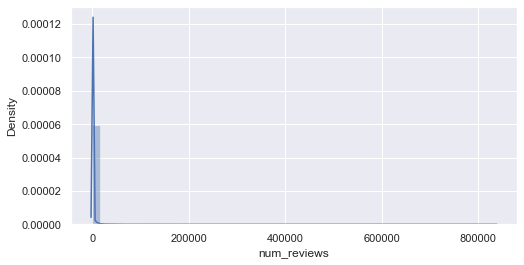

In [13]:
sns.distplot(data['num_reviews'])
plt.show()

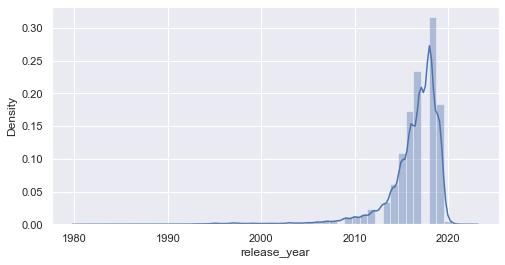

In [14]:
sns.distplot(data['release_year'])
plt.show()

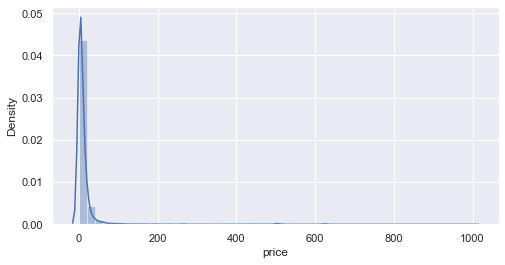

In [15]:
sns.distplot(data['price'])
plt.show()

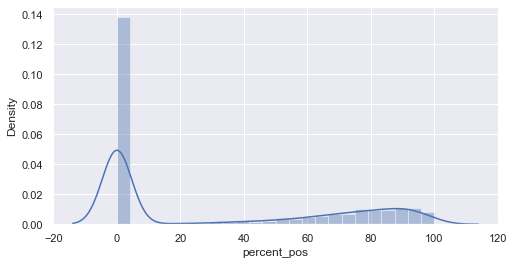

In [16]:
sns.distplot(data['percent_pos'])
plt.show()

We can see numerical variables distributions have tails. So there are skewness

In [17]:
data.describe()

,achievements,num_reviews,release_year,price,percent_pos
count,40831.000000,40831.000000,40831.000000,40831.000000,40831.000000
mean,23.065489,553.938527,2016.219490,12.272675,31.769489
std,247.628453,7557.418584,3.360928,44.732452,38.870698
min,0.000000,0.000000,1981.000000,0.000000,0.000000
25%,0.000000,0.000000,2015.000000,0.990000,0.000000
50%,0.000000,0.000000,2017.000000,4.990000,0.000000
75%,9.000000,42.000000,2018.000000,9.990000,74.000000
max,9821.000000,836608.000000,2022.000000,999.000000,100.000000


We've got our dataset cleaned. But before, we need to scale this data as we can see below the huge differences between mean and std.

## 2.3 Feature Engineering
Feature engineering gives new features to our dataset providing simpler features from the current ones to get better results on our modelling.

In [18]:
def engineering(data):
    # Age of the game
    data['age'] = 2022 - data['release_year']

    # Popularity
    conditions = [
        (data['num_reviews'] == 0),
        (data['num_reviews'] > 0) & (data['num_reviews'] < 20000),
        (data['num_reviews'] >= 20000) & (data['num_reviews'] < 40000),
        (data['num_reviews'] >= 40000)
    ]
    results = ['no reviews', 'popular', 'very popular', 'top']
    data['popularity'] = np.select(conditions, results)

    # Released
    cond2 = [
        (data['release_year'] < 2000),
        (data['release_year'] >= 2000) & (data['release_year'] < 2018),
        (data['release_year'] >= 2018)
    ]
    res2 = ['retro', 'old', 'new']
    data['retro'] = np.select(cond2, res2)

    # Rate
    cond3 = [
        (data['percent_pos'] >= 90),
        (data['percent_pos'] >= 80) & (data['percent_pos'] < 90),
        (data['percent_pos'] >= 70) & (data['percent_pos'] < 80),
        (data['percent_pos'] >= 60) & (data['percent_pos'] < 70),
        (data['percent_pos'] < 60)
    ]
    res3 = ['A', 'B', 'C', 'D', 'F']
    data['rate'] = np.select(cond3, res3)
    
    return data

In [19]:
df_eng = engineering(data)
df_eng.head()

,achievements,num_reviews,multiplayer,mature,release_year,price,percent_pos,age,popularity,retro,rate
0,54.0,42550.0,True,False,2016,19.99,92,6,top,old,A
1,37.0,836608.0,True,True,2017,29.99,49,5,top,old,F
2,128.0,7030.0,True,False,2018,39.99,71,4,popular,new,C
3,0.0,167115.0,True,False,2018,44.99,61,4,top,new,D
4,0.0,11481.0,True,False,2003,0.00,74,19,popular,old,C


## 2.4 Convert Categorical Features into integers (Label Encoding)
Transform categorical features on numerical ones. This is needed for modelling.

In [20]:
le = LabelEncoder()

df_eng['multiplayer_enc'] = le.fit_transform(df_eng['multiplayer'])
df_eng['mature_enc'] = le.fit_transform(df_eng['mature'])
df_eng['popularity_enc'] = le.fit_transform(df_eng['popularity'])
df_eng['retro_enc'] = le.fit_transform(df_eng['retro'])
df_eng['rate_enc'] = le.fit_transform(df_eng['rate'])

df_le = df_eng.drop(['multiplayer','mature','popularity','retro','rate'], axis=1)
df_le

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
0,54.0,42550.0,2016,19.99,92,6,1,0,2,1,0
1,37.0,836608.0,2017,29.99,49,5,1,1,2,1,4
2,128.0,7030.0,2018,39.99,71,4,1,0,1,0,2
3,0.0,167115.0,2018,44.99,61,4,1,0,2,0,3
4,0.0,11481.0,2003,0.00,74,19,1,0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
40828,0.0,0.0,2019,2.99,0,3,0,0,0,0,4
40829,0.0,0.0,2019,2.99,0,3,0,0,0,0,4
40830,0.0,0.0,2018,7.99,0,4,1,0,0,0,4
40831,0.0,0.0,2018,9.99,0,4,0,0,0,0,4


## Pre-processing pipeline
- 1. Unskew the data - log transformation
- 2. Standardize to the same average values
- 3. Scale to the same standard deviation
- 4. Store as a separate array to be used for clustering


## 2.5 Managing skewed variables
This is needed for K-Means. To identify skewness we use visual analysis of the distribution: if it has a tail - it's skewed

In order to remove skewed data, we need to apply a log tranformation using the numpy log() function.

**- NOTE: we are adding a constant before log transformation**

**- NOTE 2: Log transformation is used because we are dealing with POSITIVE values**

In [21]:
# Perform a log transformation of the data to unskew the data
def logtrans(df):
    c = 1
    df_log = np.log(df + c)
    return df_log

In [22]:
df_log = logtrans(df_le)
df_log

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
0,4.007333,10.658459,7.609367,3.044046,4.532599,1.945910,0.693147,0.000000,1.098612,0.693147,0.000000
1,3.637586,13.637112,7.609862,3.433665,3.912023,1.791759,0.693147,0.693147,1.098612,0.693147,1.609438
2,4.859812,8.858084,7.610358,3.713328,4.276666,1.609438,0.693147,0.000000,0.693147,0.000000,1.098612
3,0.000000,12.026443,7.610358,3.828424,4.127134,1.609438,0.693147,0.000000,1.098612,0.000000,1.386294
4,0.000000,9.348536,7.602900,0.000000,4.317488,2.995732,0.693147,0.000000,0.693147,0.693147,1.098612
...,...,...,...,...,...,...,...,...,...,...,...
40828,0.000000,0.000000,7.610853,1.383791,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,1.609438
40829,0.000000,0.000000,7.610853,1.383791,0.000000,1.386294,0.000000,0.000000,0.000000,0.000000,1.609438
40830,0.000000,0.000000,7.610358,2.196113,0.000000,1.609438,0.693147,0.000000,0.000000,0.000000,1.609438
40831,0.000000,0.000000,7.610358,2.396986,0.000000,1.609438,0.000000,0.000000,0.000000,0.000000,1.609438


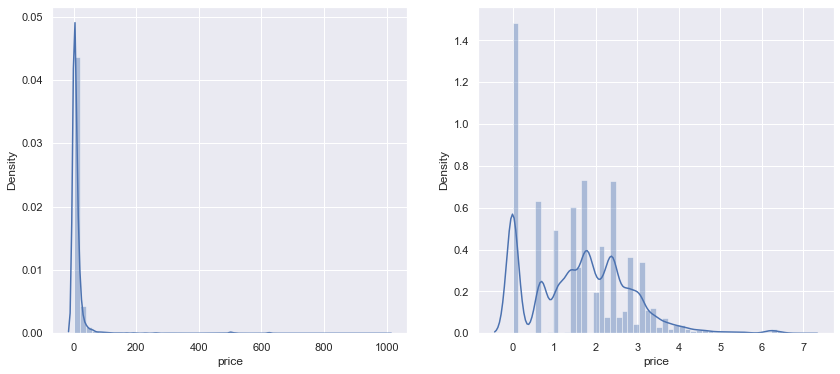

In [23]:
# Effect of Log Transformation
plt.figure(1, figsize=(14,6))
plt.subplot(1, 2, 1); sns.distplot(df_le['price'])
plt.subplot(1, 2, 2); sns.distplot(df_log['price'])

plt.show()

## 2.6 Scale data
Variables have to be on the same scale. K means assumes **equal mean and equal variance**

### 2.6.1 Scaled with StandardScaler
This function helps us to centering and scale our data

In [24]:
def scale(df):
    # Initialize a standard scaler and fit it
    scaler = StandardScaler()
    scaler.fit(df)

    # Scale and center the data
    df_normalized = scaler.transform(df)

    # Create a pandas DataFrame of the processed data
    df_processed = pd.DataFrame(data=df_normalized, index=df.index, columns=df.columns)
    
    return df_processed

In [25]:
df_normalized = scale(df_le)
df_normalized.describe()

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
count,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,40831.000000,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04
mean,5.568653e-18,2.784327e-18,2.260873e-14,-2.366678e-17,0.000000,1.225104e-16,-5.568653e-17,1.635792e-17,1.559223e-16,7.796114e-17,-6.682384e-17
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-9.314669e-02,-7.329822e-02,-1.047923e+01,-2.743607e-01,-0.817322,-1.719936e+00,-6.102659e-01,-2.762990e-01,-8.386674e-01,-1.164378e+00,-2.119250e+00
25%,-9.314669e-02,-7.329822e-02,-3.628477e-01,-2.522288e-01,-0.817322,-5.297739e-01,-6.102659e-01,-2.762990e-01,-8.386674e-01,-1.164378e+00,-7.325338e-01
50%,-9.314669e-02,-7.329822e-02,2.322333e-01,-1.628072e-01,-0.817322,-2.322333e-01,-6.102659e-01,-2.762990e-01,-8.386674e-01,7.965505e-01,6.541827e-01
75%,-5.680148e-02,-6.774070e-02,5.297739e-01,-5.103014e-02,1.086449,3.628477e-01,1.638630e+00,-2.762990e-01,1.098957e+00,7.965505e-01,6.541827e-01
max,3.956756e+01,1.106283e+02,1.719936e+00,2.205869e+01,1.755341,1.047923e+01,1.638630e+00,3.619268e+00,4.974205e+00,2.757479e+00,6.541827e-01


- We can see if we don't apply log transformation before scaling that std = 1 **BUT** max values are very differents

In [26]:
df_log_normalized = scale(df_log)
df_log_normalized.describe()

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
count,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04,4.083100e+04
mean,-4.454922e-17,-1.336477e-16,3.014201e-13,1.002358e-16,1.559223e-16,6.348265e-16,-4.454922e-17,4.420118e-17,4.454922e-17,1.670596e-16,5.568653e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00
min,-6.077904e-01,-7.618948e-01,-1.054090e+01,-1.368873e+00,-8.553274e-01,-5.019095e+00,-6.102659e-01,-2.762990e-01,-8.542390e-01,-1.178186e+00,-2.441645e+00
25%,-6.077904e-01,-7.618948e-01,-3.610920e-01,-7.959246e-01,-8.553274e-01,-6.181888e-01,-6.102659e-01,-2.762990e-01,-8.542390e-01,-1.178186e+00,-3.679921e-01
50%,-6.077904e-01,-7.618948e-01,2.323623e-01,1.215765e-01,-8.553274e-01,-1.196420e-01,-6.102659e-01,-2.762990e-01,-8.542390e-01,8.191608e-01,5.962017e-01
75%,8.830768e-01,6.948076e-01,5.288689e-01,6.268833e-01,1.172507e+00,6.670064e-01,1.638630e+00,-2.762990e-01,1.136071e+00,8.191608e-01,5.962017e-01
max,5.344050e+00,4.519721e+00,1.713429e+00,4.382599e+00,1.312299e+00,5.201326e+00,1.638630e+00,3.619268e+00,3.126380e+00,1.987534e+00,5.962017e-01


- If we apply log tranformation before scaling we get scaled values on max ones.

### 2.6.2 Scaled with MinMaxScaler

In [27]:
def mms(df):
    # Initialize a standard scaler and fit it
    ms = MinMaxScaler()
    ms.fit(df)

    # Scale and center the data
    df_scaled = ms.transform(df)

    # Create a pandas DataFrame of the processed data
    df_processed = pd.DataFrame(data=df_scaled, index=df.index, columns=df.columns)
    
    return df_processed

In [28]:
df_log_mms = mms(df_log)
df_log_mms.describe()

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
count,40831.000000,40831.000000,40831.000000,40831.000000,40831.000000,40831.000000,40831.000000,40831.000000,40831.00000,40831.000000,40831.000000
mean,0.102118,0.144254,0.860178,0.238004,0.394592,0.491085,0.271362,0.070927,0.21460,0.372170,0.803742
std,0.168017,0.189338,0.081605,0.173871,0.461340,0.097845,0.444668,0.256705,0.25122,0.315888,0.329185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.830711,0.099618,0.000000,0.430599,0.000000,0.000000,0.00000,0.000000,0.682606
50%,0.000000,0.000000,0.879139,0.259142,0.000000,0.479379,0.000000,0.000000,0.00000,0.630930,1.000000
75%,0.250488,0.275806,0.903335,0.346999,0.935509,0.556347,1.000000,0.000000,0.50000,0.630930,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


- With MinMaxScaler we don't get negative values, we are getting values between 0 and 1 **BUT** we have got different mean and std values 

# 2. Data visualization

## 2.1 Visualize data distributions

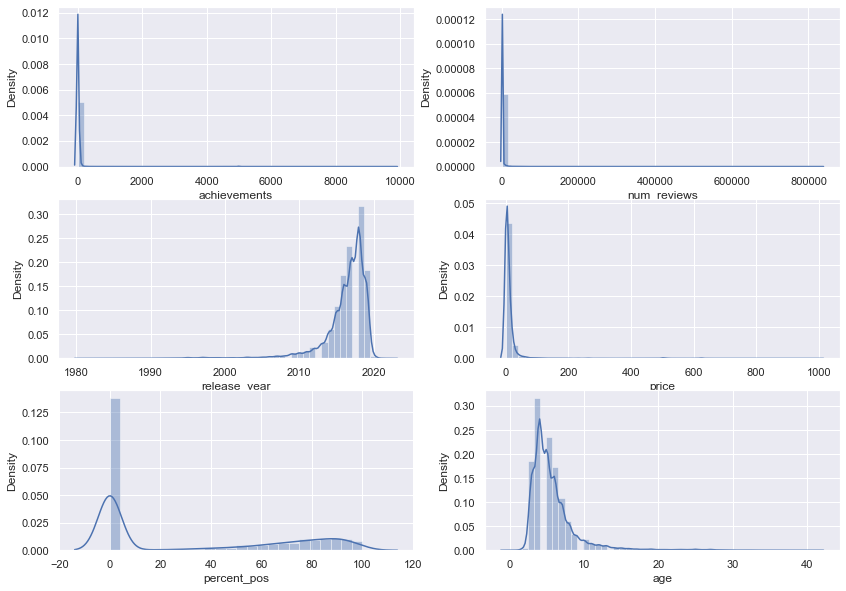

In [29]:
plt.figure(1, figsize=(14,10))
plt.subplot(3, 2, 1); sns.distplot(df_eng['achievements'])
plt.subplot(3, 2, 2); sns.distplot(df_eng['num_reviews'])
plt.subplot(3, 2, 3); sns.distplot(df_eng['release_year'])
plt.subplot(3, 2, 4); sns.distplot(df_eng['price'])
plt.subplot(3, 2, 5); sns.distplot(df_eng['percent_pos'])
plt.subplot(3, 2, 6); sns.distplot(df_eng['age'])

plt.show()

## 2.2 Visualize the normalized variables

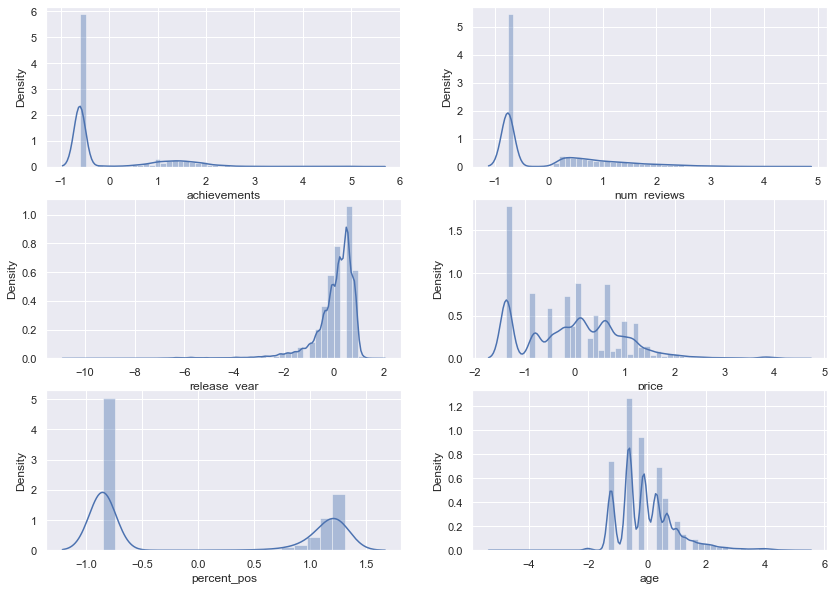

In [30]:
plt.figure(1, figsize=(14,10))
plt.subplot(3, 2, 1); sns.distplot(df_log_normalized['achievements'])
plt.subplot(3, 2, 2); sns.distplot(df_log_normalized['num_reviews'])
plt.subplot(3, 2, 3); sns.distplot(df_log_normalized['release_year'])
plt.subplot(3, 2, 4); sns.distplot(df_log_normalized['price'])
plt.subplot(3, 2, 5); sns.distplot(df_log_normalized['percent_pos'])
plt.subplot(3, 2, 6); sns.distplot(df_log_normalized['age'])

plt.show()

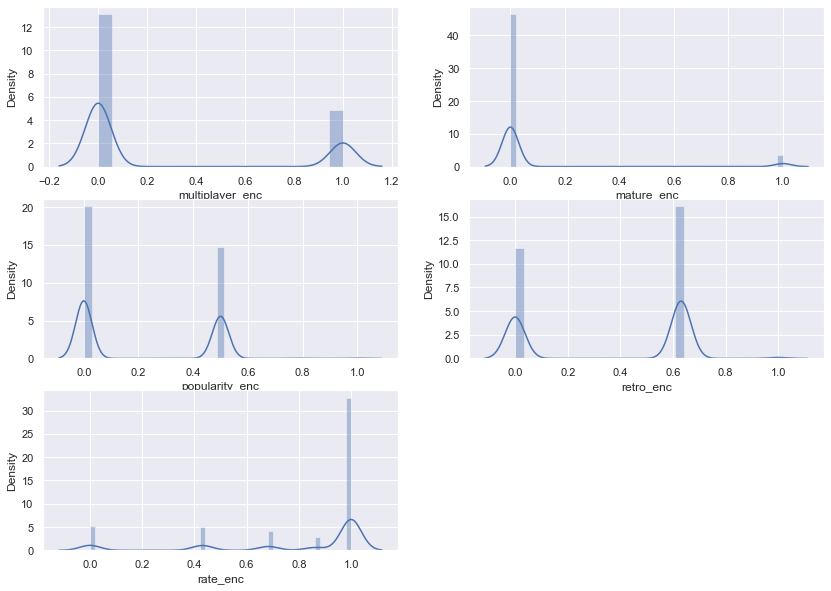

In [31]:
plt.figure(1, figsize=(14,10))
plt.subplot(3, 2, 1); sns.distplot(df_log_mms['multiplayer_enc'])
plt.subplot(3, 2, 2); sns.distplot(df_log_mms['mature_enc'])
plt.subplot(3, 2, 3); sns.distplot(df_log_mms['popularity_enc'])
plt.subplot(3, 2, 4); sns.distplot(df_log_mms['retro_enc'])
plt.subplot(3, 2, 5); sns.distplot(df_log_mms['rate_enc'])

plt.show()

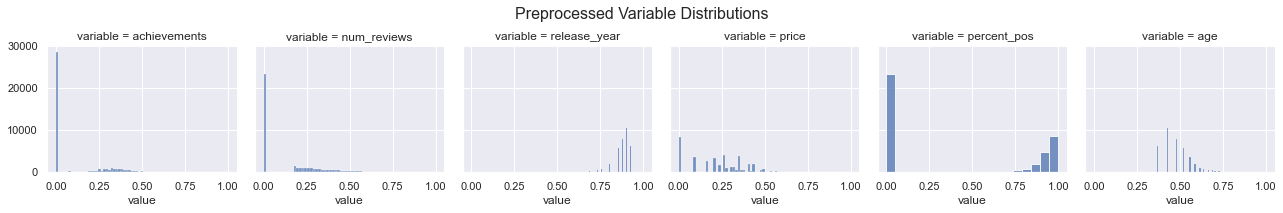

In [32]:
# Plot the distributions of the original variables
g = sns.FacetGrid(df_log_mms[['achievements','num_reviews','release_year','price','percent_pos','age']].melt(), col="variable")
g.map(sns.histplot, "value")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Preprocessed Variable Distributions", fontsize=16)
plt.show()

We can see release_year and age has correlation with percent_pos

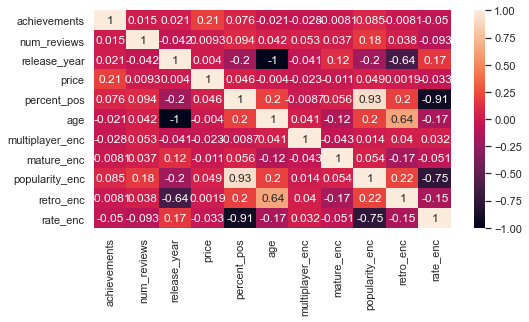

In [33]:
# Generate and print pairwise correlation of columns
cm = df_le.corr()

# Plot the correlation matrix nicely using Seaborn
sns.heatmap(cm, annot=True)
plt.show()

# 3. Model evaluation

- df_le
- df_eng (df_le + eng)
- df_ohe (df_le + eng + ohe)
- df_log (df_le + eng + ohe + log)
- df_log_normalized (df_le + eng + ohe + log + standard scaler)
- df_log_mms (df_le + eng + ohe + log + log + standard scaler)

## 3.1 Baseline Model (K-Means model with 2 clusters)
- Baseline model will be the one who provides a inertia (not normalized metric) with a non scaled model and 2 clusters
- Lower inertias are better and zero is the optimal one. In other words, lesser inertia, better model fit.

In [34]:
def km(df):
    kmeans = KMeans(n_clusters=2, random_state=1) 

    kmeans.fit(df)

    sse = kmeans.inertia_
    
    return sse

In [35]:
print('Non-scaled data inertia from df_ohe: ', km(df_le))
print('Log transformed inertia from df_log: ', km(df_log))
print('Log trans std scaler data inertia from df_log_normalized: ', km(df_log_normalized))
print('Log trans min max scaler from df_log_mms: ', km(df_log_mms))

Non-scaled data inertia from df_ohe:  964622091756.365
Log transformed inertia from df_log:  218246.8818908654
Log trans std scaler data inertia from df_log_normalized:  301706.1172213289
Log trans min max scaler from df_log_mms:  20122.275360201613


- Best inertia results are from Min Max Scaler. We can set up as a Baseline Model this one

## 3.2 Choosing the number of clusters
- We are going to use the Elbow method which is a visual method. We choose the number of cluster where the elbow is

In [36]:
def num_clusters(df, clusters):
	# Initialize empty dictionary to store sum of squared errors
    sse = {}
    
    # Fit KMeans and calculate SSE for each k
    for k in range(1, clusters):
        # Initialize KMeans with k clusters
        kmeans = KMeans(n_clusters=k, random_state=1)
        # Fit KMeans on the normalized dataset
        kmeans.fit(df)
        # Assign sum of squared distances to k element of dictionary
        sse[k] = kmeans.inertia_

    # Initialize a figure of set size
    plt.figure(figsize=(10, 4))

    # Create an elbow plot of SSE values for each key in the dictionary
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

    # Add labels to the plot
    plt.title("Elbow Method Plot", fontsize=16)  # Add a title to the plot
    plt.xlabel("Number of Clusters")  # Add x-axis label
    plt.ylabel("SSE")  # Add y-axis label

    # Show the plot
    plt.show()
    
    return sse

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f302e533700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/local/lib/python3.8/dist-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f302e533310>
Traceback 

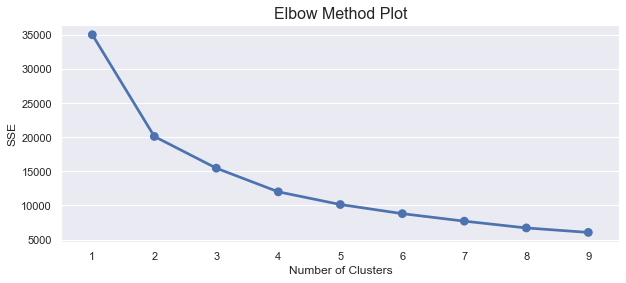

In [37]:
# Set the maximum number of clusters to plot
max_clusters = 10

baseline_model = num_clusters(df_log_mms, max_clusters)

How to find the right k?
- Elbow method: only gives an indication of optimal k.
- Other methods: average silhouette and gap statistic

From the graphic k is between 2 and 3.

## 3.3 Summary statistics of each cluster

Run k-means for k values around the recommended value

In [38]:
kmeans = KMeans(n_clusters=2, random_state=1) 

# Compute K-Means on pre-processed data
kmeans.fit(df_log_mms)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

# Create a cluster label column in the original df
k2_model = df_log_mms.assign(Cluster = cluster_labels)

# Calculate averages and size for each cluster
k2_model.groupby(['Cluster']).agg({
    'achievements': ['mean','count'], 
    'num_reviews': 'mean',
    'release_year': 'mean', 
    'price': 'mean', 
    'percent_pos' : 'mean',
    'age': 'mean',
    'multiplayer_enc': 'mean',
    'mature_enc': 'mean',
    'popularity_enc': 'mean',
    'retro_enc': 'mean',
    'rate_enc' : 'mean'
}).round(0)

achievements        num_reviews release_year price percent_pos  age  \
                mean  count        mean         mean  mean        mean mean   
Cluster                                                                       
0                0.0  23498         0.0          1.0   0.0         0.0  0.0   
1                0.0  17333         0.0          1.0   0.0         1.0  1.0   

        multiplayer_enc mature_enc popularity_enc retro_enc rate_enc  
                   mean       mean           mean      mean     mean  
Cluster                                                               
0                   0.0        0.0            0.0       0.0      1.0  
1                   0.0        0.0            1.0       0.0      1.0

### 3.5 Reviewing solutions

In [39]:
kmeans = KMeans(n_clusters=3, random_state=1) 

# Compute K-Means on pre-processed data
kmeans.fit(df_log_mms)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

# Create a cluster label column in the original df
k3_model = df_log_mms.assign(Cluster = cluster_labels)

# Calculate averages and size for each cluster
k3_model.groupby(['Cluster']).agg({
    'achievements': ['mean','count'], 
    'num_reviews': 'mean',
    'release_year': 'mean', 
    'price': 'mean', 
    'percent_pos' : 'mean',
    'age': 'mean',
    'multiplayer_enc': 'mean',
    'mature_enc': 'mean',
    'popularity_enc': 'mean',
    'retro_enc': 'mean',
    'rate_enc' : 'mean'
}).round(0)

achievements        num_reviews release_year price percent_pos  age  \
                mean  count        mean         mean  mean        mean mean   
Cluster                                                                       
0                0.0   6391         0.0          1.0   0.0         0.0  0.0   
1                0.0  17167         0.0          1.0   0.0         0.0  0.0   
2                0.0  17273         0.0          1.0   0.0         1.0  1.0   

        multiplayer_enc mature_enc popularity_enc retro_enc rate_enc  
                   mean       mean           mean      mean     mean  
Cluster                                                               
0                   1.0        0.0            0.0       0.0      1.0  
1                   0.0        0.0            0.0       0.0      1.0  
2                   0.0        0.0            1.0       0.0      1.0

In [40]:
# Add a Cluster column
df_log_mms = pd.DataFrame(df_log_mms,
                         index = df_le.index,
                         columns = df_le.columns)
df_log_mms['Cluster'] = k3_model['Cluster']

Relative importance

In [42]:
cluster_avg = k3_model.groupby(['Cluster']).mean()
population_avg = df_le.mean()
relative_imp = cluster_avg / population_avg - 1 # substract 1 because we want to remove 0 value.
relative_imp.round(2)

,achievements,num_reviews,release_year,price,percent_pos,age,multiplayer_enc,mature_enc,popularity_enc,retro_enc,rate_enc
Cluster,,,,,,,,,,,
0,-1.00,-1.0,-1.0,-0.98,-1.00,-0.92,2.69,-0.41,-0.99,-0.43,-0.67
1,-1.00,-1.0,-1.0,-0.98,-1.00,-0.92,-1.00,-0.07,-1.00,-0.49,-0.67
2,-0.99,-1.0,-1.0,-0.98,-0.97,-0.91,0.00,0.22,0.17,-0.23,-0.82


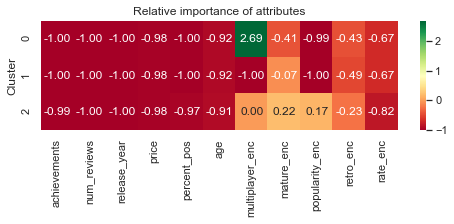

In [43]:
# Plot heatmap
plt.figure(figsize=(8,2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

# Final thoughts

We have our conclusions from the heatmap. The most important feature is the multiplayer feature. There are 2 more less important but they give us a proximity to two important features. Of course we should refine hyperparameters and improve the model to get better findings.

So we accomplish our Business Goal: **We just need 3 out of 5 groupings (multiplayer, mature, popularity)**
Our KPI was the inertia. We compared 2 models, one scaled with MinMaxScaler and the other one StandardScaler. We should use anothers to see whether the KPI improves.

Logarithmic transformation seems to work quite badly, distribution plots do not show very good results, there are tails on the left and right side and we can not see a good normal distribution. This might cause a bad performing on our results.

Finally I have decided to see the results with 3 clusters because is the best result aside from 2 clusters.

- I should have created classes in order to improve the code but for Data Science purpose I have created just single functions
- I can improve the model by going further on date feature and taking datetime features from it.
- We can think of removing features with a high standard deviation. 